<font size = "5"> **Chapter 3: [Imaging](CH3_00-Imaging.ipynb)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />



# Linear Image Approximation: Weak Phase Object


[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM/main/Imaging/CH3_04-Linear_Image_Approximation.ipynb)


part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>

by Gerd Duscher, Spring 2022

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
Materials Science & Engineering<br>
The University of Tennessee, Knoxville

Background and methods to analysis and quantification of data acquired with transmission electron microscopes.



## Load important packages

### Check Installed Packages

In [ ]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = get_distribution(package_name).version
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2022.3.1':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q
# ------------------------------
print('done')

### Load Packages
We will use 
- numpy and matplotlib (installed with magic comand **%pylab**.)
- physical constants from scipy
- The pyTEMlib kinematic scattering librarty is only used to determine the wavelength.

In [1]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
%pylab --no-import-all notebook
    
import warnings
warnings.filterwarnings('ignore')

import scipy.constants

# Import libraries from the book
import pyTEMlib
import pyTEMlib.kinematic_scattering as ks
import pyTEMlib.dynamic_scattering as ds

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)

__notebook__ = 'CH3-04-Linear_Image_Approximation'
__notebook_version__ = '2021_03_17'

Populating the interactive namespace from numpy and matplotlib
Symmetry functions of spglib enabled
Using kinematic_scattering library version {_version_ }  by G.Duscher
pyTEM version:  0.2022.3.1



## Weak Phase Object

the simplest approximation is for the sample to be very thin and then then the incident electrons pass through the specimen with only small
deviations in their paths, which can be approximated by a phase change only.
These influeces of a specimen can be modeled as a simple
transmission function $t (x)$. The electron wave function after passing through the
specimen is:
$$
\Psi_t(x) = t(x) \Psi_{inc}(x)
$$

with $\Psi_{inc}$:incident wave  function

This transmisison function is the same that we used for a thin slice in  the multislice algorithm.
So we approximate here a sample by a thin slice.

The exit wave is then distorted by the aberration function $\chi(\vec{k})$ of the objective lens.
Because this distortion function is defined in reciprocal space it is convenient to address the image distortion as a convolution. We descibe this effect of the objective lens as shifts to the phase of each frequency component by a different amount according to the aberration function $\chi(\vec{k})$. this convolution is a multiplicaiton in Fourier Space. 

## Projected Potential of Supercell
As in the Dynamic Diffraction part in the [Multislice notebook](../Diffraction/CH2_D02-Multislice.ipynb), we first define a potential.

I put the code from that notebook into a library ``dynamic_scattering``which we will use here.

Here we make a bcc iron crystal, which is unrealistically thin (1 unit cell).

<IPython.core.display.Javascript object>


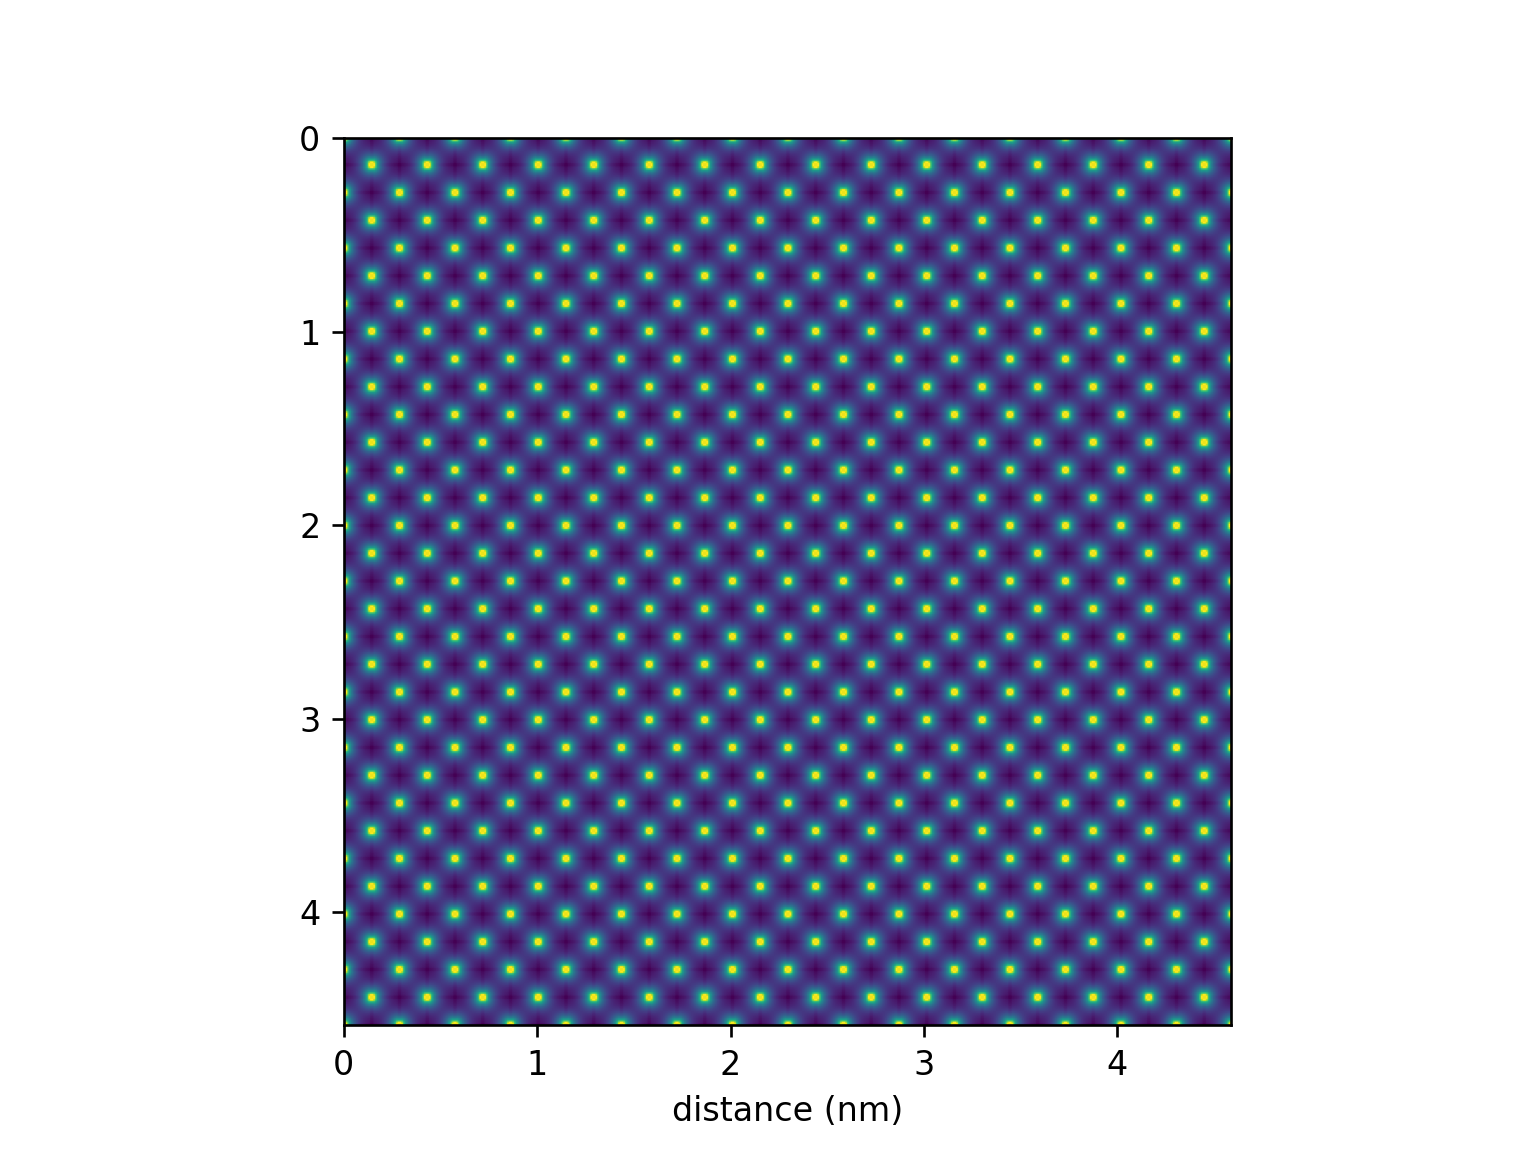

Text(0.5, 0, 'distance (nm)')

In [2]:
nx = ny = 512
n_cell_x = 16
a = 0.2866

potential = ds.potential_2dim('Fe', nx, nx, n_cell_x, n_cell_x, a, [[0,0], [0.5,0.5]])

pixel_size = a/(nx/n_cell_x)
image_extent=[0,nx*pixel_size, ny*pixel_size, 0 ]
plt.figure()
plt.imshow((potential), extent=image_extent)
plt.xlabel('distance (nm)')

## Transmission Function for Very Thin Specimen

For a very thin specimen the ``weak phase approximation`` is the simples way to calculate a high resolution (phase contrast) image.  
In that approximation, the sample causes only a phase change to the incident plane wave.


To retrieve the exit we just multiply the transmission function $t(\vec{x})$ with the plane wave $\exp (2\pi i k_z z)$

$$ \Psi_t(\vec{x}) = t(\vec{x}) \exp \left(2 \pi i k_z z \right) \approx t(\vec{x})  $$

The specimen transmission function depends on the projected potential $v_z(\vec{x})$ and the interaction parameter $\sigma$:
$$t(\vec{x}) =  \exp \left( i \sigma v_z(\vec{x})\right)$$

with the interaction parameter $\sigma$:
$$ 
\sigma = \frac{2 \pi}{\lambda V} \left(  \frac{m_0 c^2 + eV}{2m_0c^2+eV} \right) = \frac{2 \pi m  e_0 \lambda}{h^2}
$$
with $ m = \gamma m_0$ and $eV$ the incident electron energy.

Again we did this already in the Multislice notebook, and I put the code from that notebook into the ``dynamic_scattering`` library.

<IPython.core.display.Javascript object>


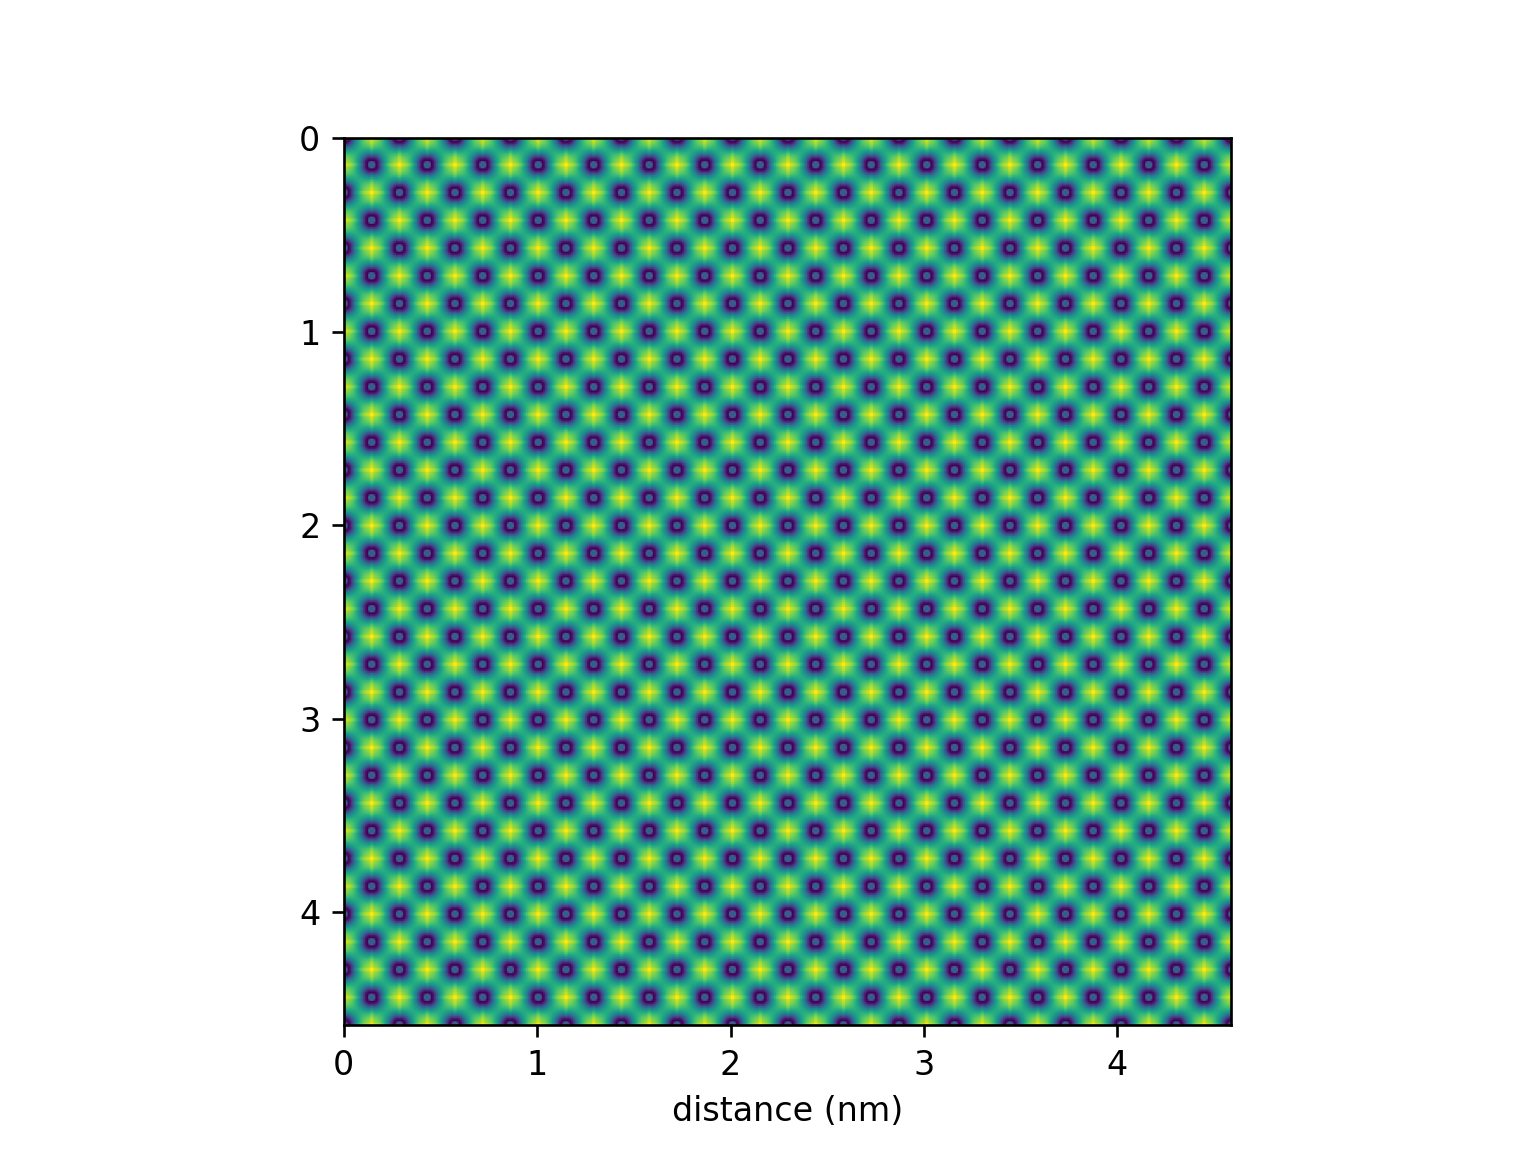

Text(0.5, 0, 'distance (nm)')

In [3]:
acceleration_voltage = 200000

transmission = ds.get_transmission(potential, acceleration_voltage)

plt.figure()
plt.imshow(transmission.real, extent = image_extent)
plt.xlabel('distance (nm)')



Please note that there is no effect by multiplying with a plane wave

<IPython.core.display.Javascript object>


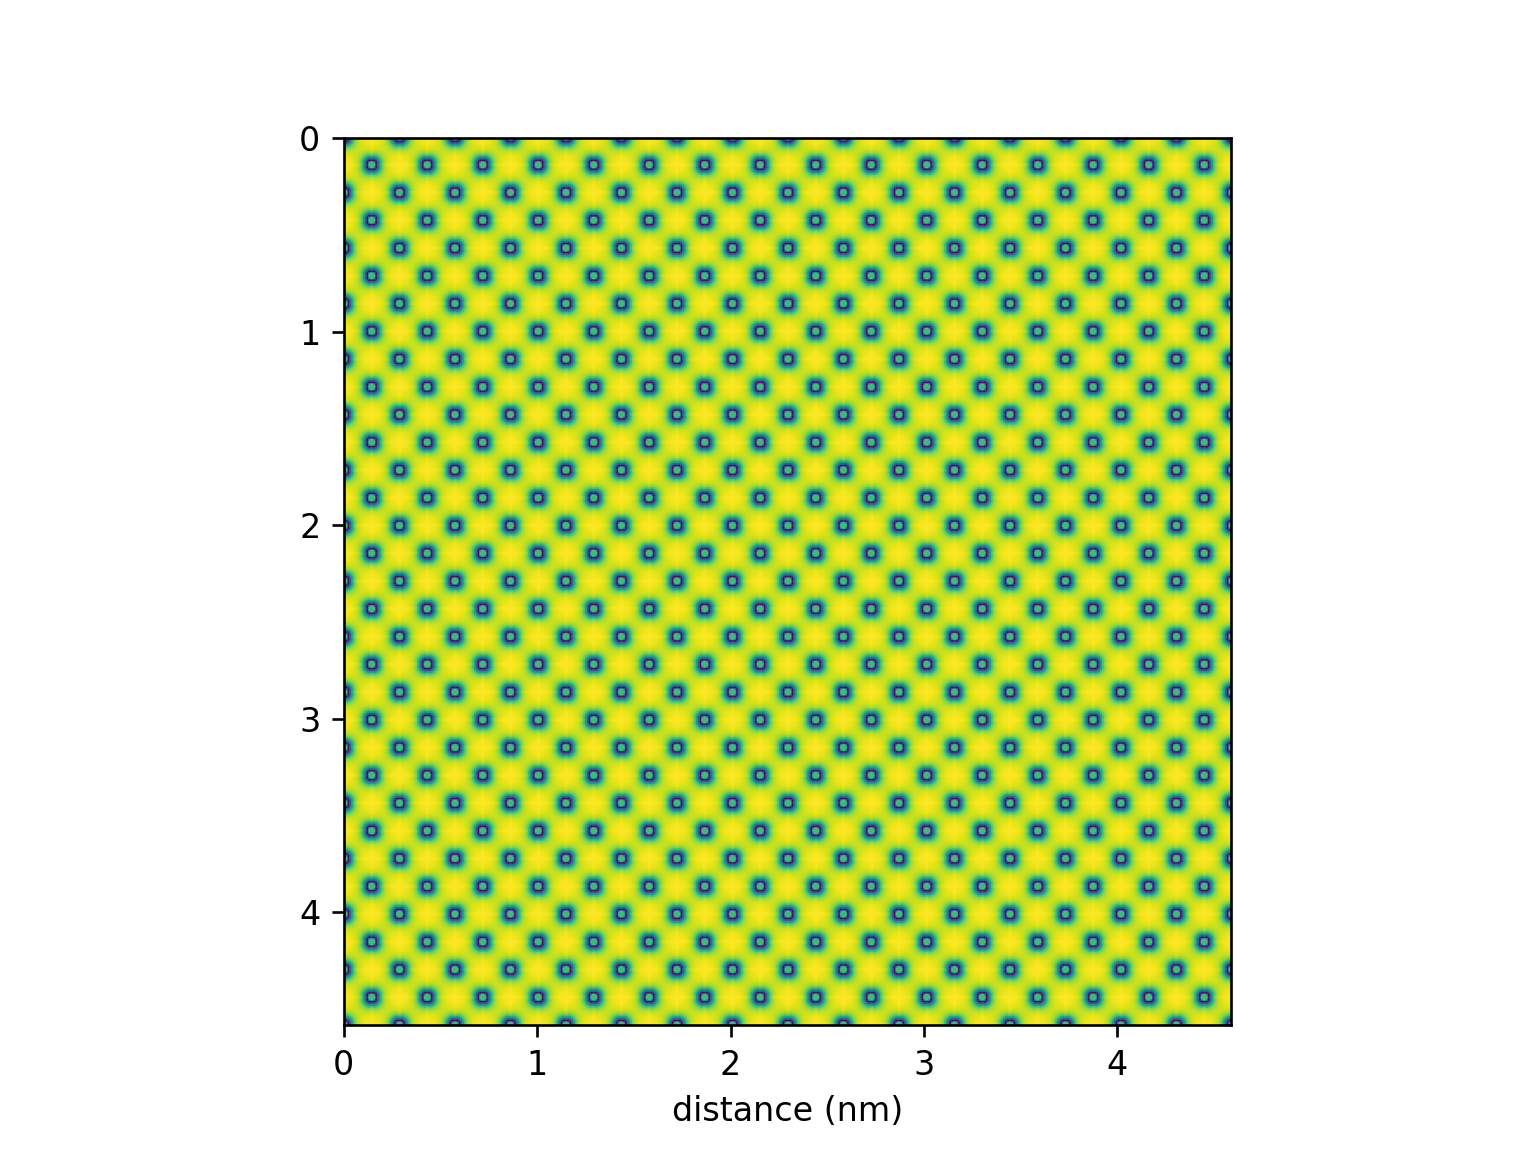

Text(0.5, 0, 'distance (nm)')

In [4]:
plane_wave = np.ones([nx,ny], dtype=complex)

exit_wave = plane_wave * transmission

plt.figure()
plt.imshow(np.abs(exit_wave.imag), extent=image_extent)
plt.xlabel('distance (nm)')

## Aberration Function

We make the aberration function like in the [Contrast Transfer notebook](CH3_03-CTF.ipynb)

<IPython.core.display.Javascript object>


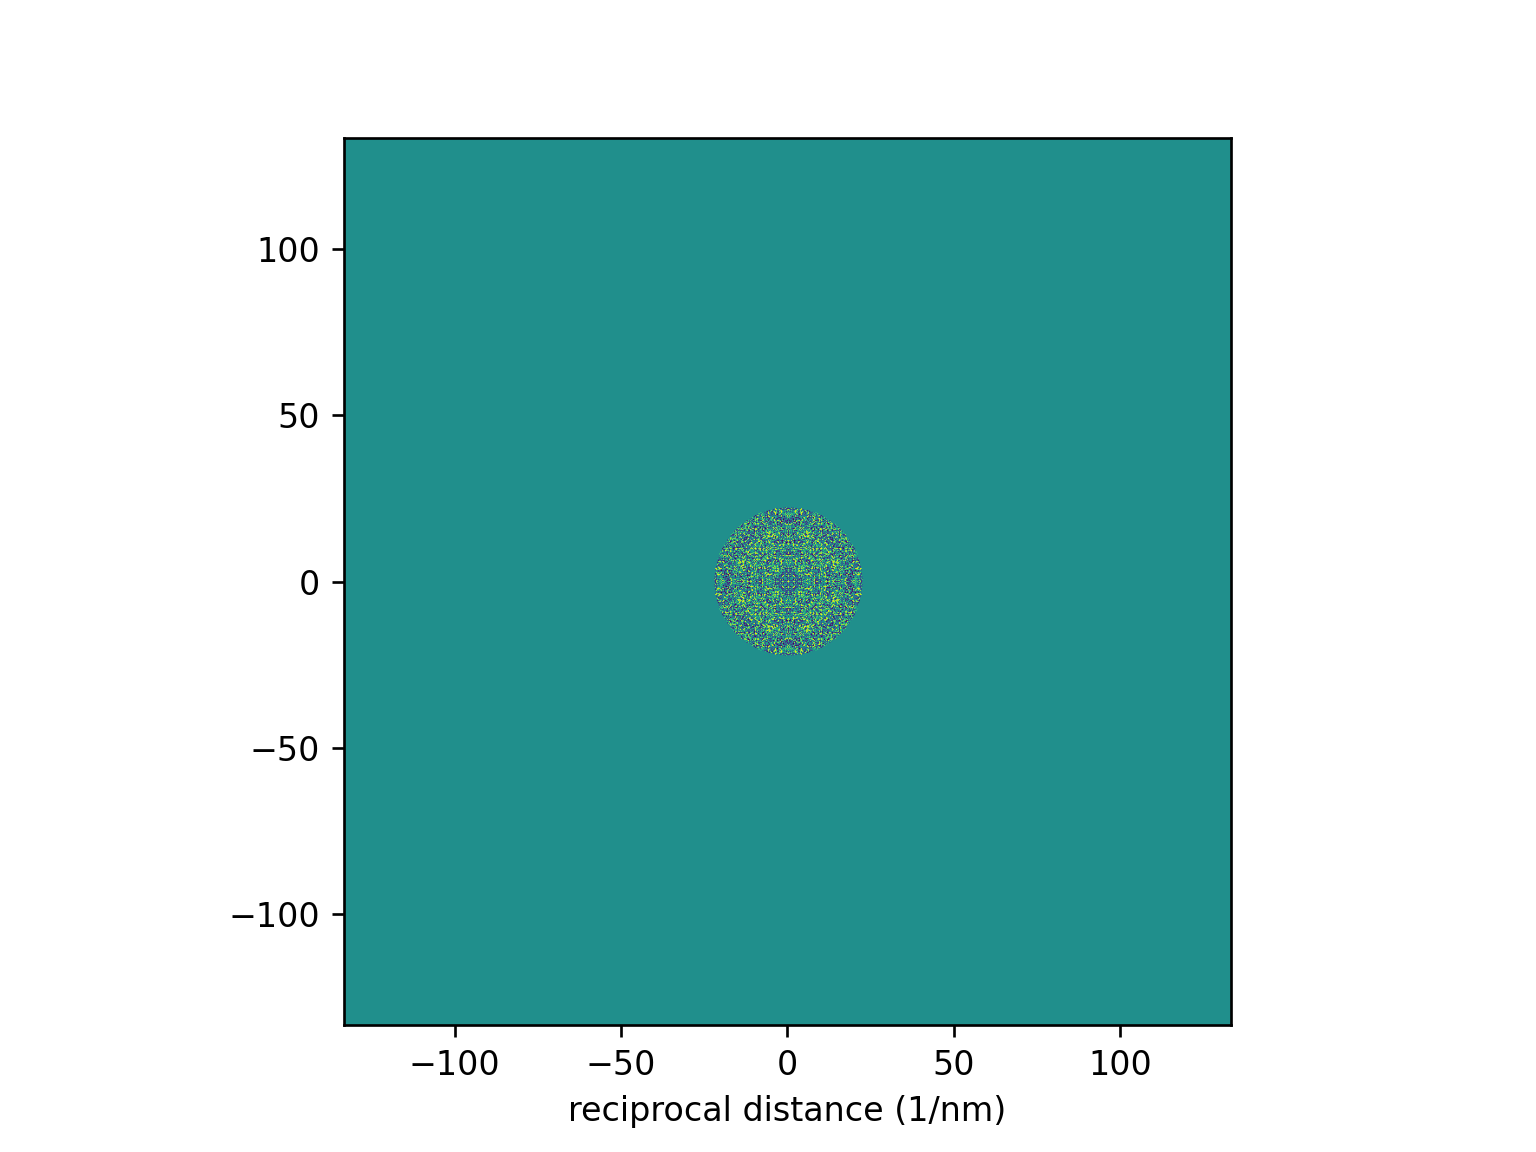

In [16]:
def make_chi(theta, phi, wavelength, ab):
    """Calculate aberration function chi
    
    Input:
    ------
    theta, phi: numpay array (n x m)
        angle meshes of the reciprocal space
    wavelength: float
        wavelength in nm
    ab: dict
        aberrations in nm should at least contain defocus (C10), and spherical abeeration (C30) 
        
    Returns:
    --------
    chi: numpy array (nxm)
        aberration function 
    """
    if 'C10' not in ab:
        ab['C10'] = 0.
    if 'C12a' not in ab:
        ab['C12a'] = 0.
    if 'C12b' not in ab:
        ab['C12b'] = 0.
    # defocus and astigmatism
    t1 = np.power(theta, 2)/2 * (ab['C10']  + ab['C12a'] * np.cos(2 * phi) + ab['C12b'] * np.sin(2 * phi))
    

    # coma and three fold astigmatism
    if 'C21a' in ab and 'C21b' in ab and 'C23a' in ab and 'C23b' in ab:
        t2 = np.power(theta, 3)/3 * (ab['C21a'] * np.cos(1*phi) + ab['C21b'] * np.sin(1*phi))
    else:
        t2 = theta*0.
    # spherical aberration
    if 'C30' not in ab:
        ab['C30'] = 0.
    t3 = np.power(theta, 4)/4 * ab['C30']
                              
    chi = t1 + t2+ t3
    return chi * 2 * np.pi / wavelength  # np.power(theta,6)/6*(  ab['C50'] )
                           
def objective_lens_function(ab, nx, ny, field_of_view, wavelength, aperture_size=10):
    """Objective len function to be convoluted with exit wave to derive image function
    
    Input:
    ab: dict
        aberrations in nm should at least contain defocus (C10), and spherical abeeration (C30) 
    nx: int
        number of pixel in x direction
    ny: int
        number of pixel in y direction
    field_of_view: float
        field of fiew of potential
    wavelength: float
        wavelength in nm
    aperture_size: float
        aperture size in 1/nm
        
    Returns:
    --------
    object function: numpy array (nx x ny)
    extent: list
    """
    
    # Reciprocal plane in 1/nm
    dk = 1 / field_of_view
    t_xv, t_yv = np.mgrid[int(-nx/2):int(nx/2),int(-ny/2):int(ny/2)] *dk

    # define reciprocal plane in angles
    phi = np.arctan2(t_yv, t_xv)
    theta = np.arctan2(np.sqrt(t_xv**2 + t_yv**2), 1/wavelength)

    mask = theta < aperture_size * wavelength

    # calculate chi
    chi = make_chi(theta, phi, wavelength, ab)
    
    extent = [-nx/2*dk, nx/2*dk, -nx/2*dk,nx/2*dk]
    return np.exp(-1j*chi)*mask, extent

acceleration_voltage = 200000
ab={'C10':-84.0, 'C12a':0.0, 'C12b':0.0, 'C30': 2.2*1e6} # aberrations in nm

wavelength = ks.get_wavelength(acceleration_voltage)*10

objective_lens, extent = objective_lens_function(ab, nx, nx, nx*pixel_size, wavelength, 1/.18)
plt.figure()
plt.imshow(objective_lens.real, extent=extent)
plt.xlabel('reciprocal distance (1/nm)');


## Image Simulation in Weak Phase Approximation

In the weak phase approximation the image is just the convoltuion of the transmission function and the objective lens funtion.

If an aperture selects only the inner smooth part of the objetive function in Scherzer defocus, the image is naively to interpret as the dark parts as the atoms (remember the CTF is negative in that case)

<IPython.core.display.Javascript object>


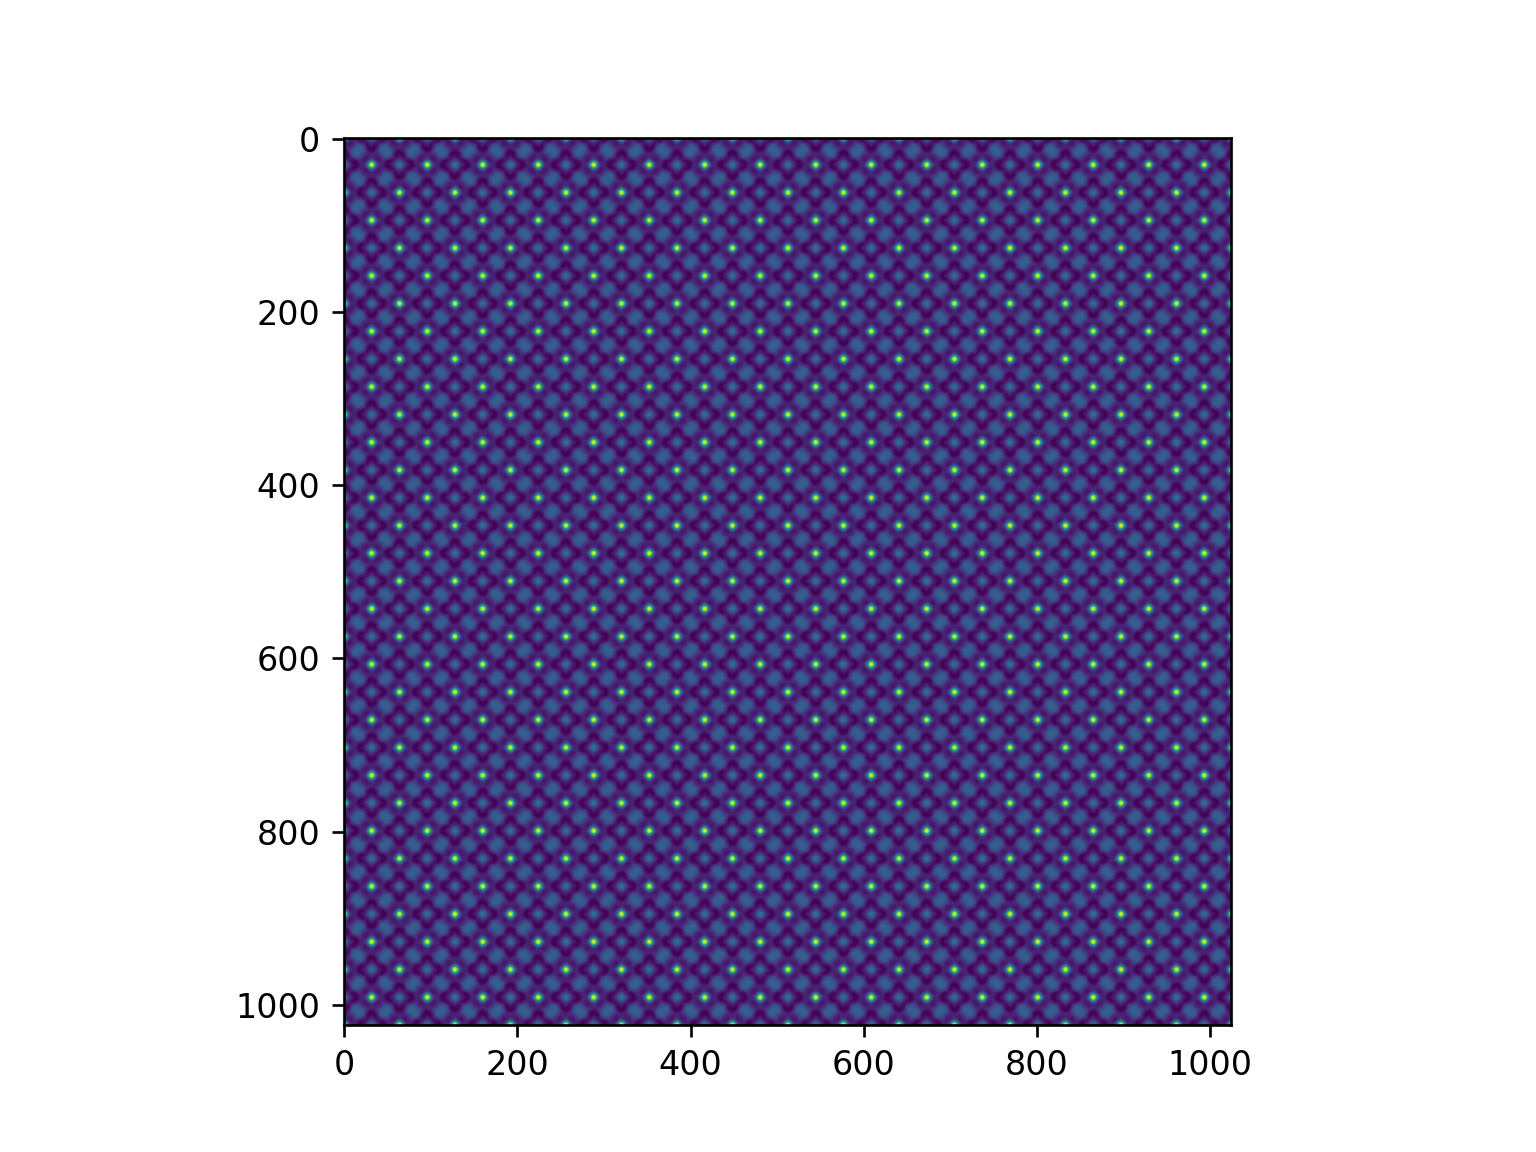

In [17]:
Q_k = np.fft.fftshift(np.fft.fft2(transmission))

psi_r =  np.fft.fftshift(np.fft.ifft2((Q_k*objective_lens)))

image  = np.real(psi_r*np.conjugate(psi_r))

plt.figure()
plt.imshow(image.real);

## Influence of Aberrations on Image

Within this weak phase object aberration, we can already investigate the influence of lens aberrations on the image.

We do now all steps together and check the effect of the aberration, acceleration voltage, aperture, and element onto the final image (in weak phase approximation).



<IPython.core.display.Javascript object>


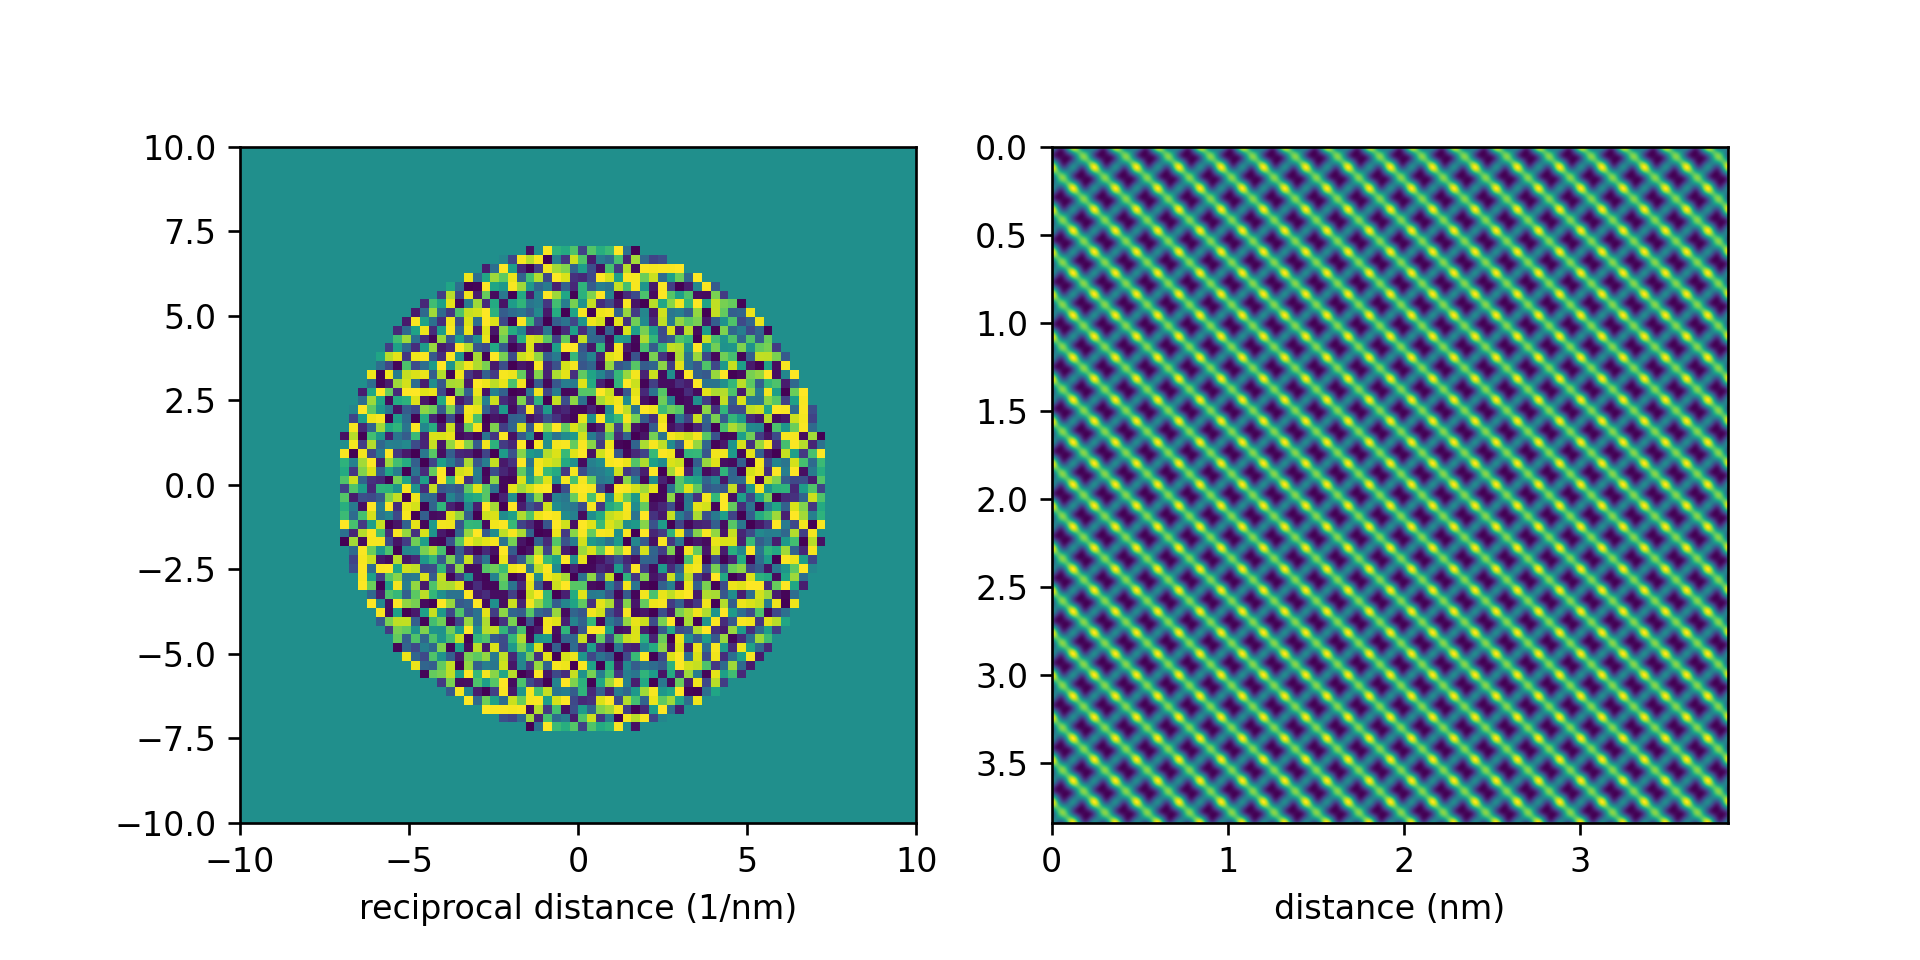

Text(0.5, 0, 'distance (nm)')

In [20]:
# -----Input -----
ab={'C10':-88.0, 'C12a': 00.0, 'C12b': 100.0, 'C30': 2.2*1e6} # aberrations in nm
# -------------

nx = ny = 1024
n_cell_x = 16
a = 0.24
acceleration_voltage = 200000
resolution = 0.14


potential = ds.potential_2dim('Au', nx, nx, n_cell_x, n_cell_x, a, [[0,0], [0.5,0.5]])
pixel_size = a/(nx/n_cell_x)

transmission = ds.get_transmission(potential, acceleration_voltage)

wavelength = ks.get_wavelength(acceleration_voltage)
objective_lens, extent_r = objective_lens_function(ab, nx, nx, nx*pixel_size, wavelength, 1/resolution)

Q_k = np.fft.fftshift(np.fft.fft2(transmission))
psi_r =  np.fft.fftshift(np.fft.ifft2((Q_k*objective_lens)))
image  = np.real(psi_r*np.conjugate(psi_r))


fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(objective_lens.real, extent=extent_r)
ax[0].set_xlabel('reciprocal distance (1/nm)')
ax[0].set_xlim(-10,10)
ax[0].set_ylim(-10,10)

ax[1].imshow(image.real, extent=[0,nx*pixel_size, ny*pixel_size, 0 ])
ax[1].set_xlabel('distance (nm)')

## Summary


The weak phase object allows for a fast check on image parameters. For a quantitative image simulation we need to do dynamic scattering theory. Please go to the  [Defocus-Thickness notebook](CH3_05-Defocus_Thickness.ipynb)
